In [38]:
import numpy as np
import csv
import pandas as pd

from collections import Counter
from numpy import linalg as LA

In [39]:
with open("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.data") as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split()
      newLines.append(newLine)

with open("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.csv", 'w') as test_file:
   file_writer = csv.writer(test_file)
   file_writer.writerows(newLines)

In [40]:
# reading csv files
data =  pd.read_csv("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.csv",
                    names=["sequence_name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "protein_local"])
print(data)

     sequence_name   mcg   gvh   alm   mit  erl  pox   vac   nuc protein_local
0       ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22           MIT
1       ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22           MIT
2       ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22           MIT
3       AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22           NUC
4       AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22           MIT
...            ...   ...   ...   ...   ...  ...  ...   ...   ...           ...
1479    YUR1_YEAST  0.81  0.62  0.43  0.17  0.5  0.0  0.53  0.22           ME2
1480    ZIP1_YEAST  0.47  0.43  0.61  0.40  0.5  0.0  0.48  0.47           NUC
1481    ZNRP_YEAST  0.67  0.57  0.36  0.19  0.5  0.0  0.56  0.22           ME2
1482    ZUO1_YEAST  0.43  0.40  0.60  0.16  0.5  0.0  0.53  0.39           NUC
1483    G6PD_YEAST  0.65  0.54  0.54  0.13  0.5  0.0  0.53  0.22           CYT

[1484 rows x 10 columns]


In [41]:
X = data.iloc[:, 1:9].values
y = data.iloc[:, 9].values

In [47]:
def p_estimate_parzen_window(x,h,X,y):

  classes = np.unique(y)

  concat = np.hstack((X,np.expand_dims(y, axis=1)))

  p_list = []

  for i in classes:

    input_values_class = concat[concat[:,-1]==i, 0:-1]

    sub = (x - input_values_class)/h

    cte = (1/(np.sqrt(2)*np.pi))

    K = np.prod(cte*np.exp(-sub.astype(float)**2/2),axis=1)

    p = sum(K)

    n_i = len(sub)

    d = len(sub[0])

    p_list.append([i,p/(n_i*(h**d))])
    
    p = 0

  return p_list

In [48]:
%%time

x = np.array([0.58, 0.61, 0.47, 0.13, 0.5, 0.0, 0.48, 0.22])

h = 0.1

print(p_estimate_parzen_window(x,h,X,y))

[['CYT', 69.33238643122478], ['ERL', 1.0379210962734828e-05], ['EXC', 28.406117524693766], ['ME1', 9.938011012213677], ['ME2', 37.504110365722426], ['ME3', 47.08696448872214], ['MIT', 43.180589385501904], ['NUC', 41.83642494029781], ['POX', 30.946992539259973], ['VAC', 60.555157564944054]]
CPU times: user 4.71 ms, sys: 4.03 ms, total: 8.75 ms
Wall time: 13.7 ms


In [49]:
def probability_priori(y):
  """return a list with each priori probability"""

  pr_pb = Counter(y)

  total = sum(pr_pb.values(), 0.0)

  for key in pr_pb:
    pr_pb[key] /= total  

  return pr_pb

In [50]:
class Parzen:
    def __init__(self, h=1):
        self.h = h

    def predict(self,x,X,y):

      pp = probability_priori(y)

      predict_parzen = []

      for x_i in x:

        parzen = p_estimate_parzen_window(x_i,self.h,X,y)

        parzen_probs = []

        for n,i in enumerate(parzen):
          num = pp[parzen[n][0]]*parzen[n][1]
          den = 0
          for k,j in enumerate(parzen):
            den+= pp[parzen[k][0]]*parzen[k][1]

          parzen_probs.append(num/den)

        predict_parzen.append(parzen[parzen_probs.index(max(parzen_probs))][0])

      return predict_parzen

In [51]:
%%time

a = Parzen(h=0.01)

train_predict = a.predict(X[0:],X,y)

CPU times: user 5.15 s, sys: 12 ms, total: 5.17 s
Wall time: 5.17 s


In [52]:
y_train = data.iloc[:, 9].values

sum([1 for n,i in enumerate(y_train) if train_predict[n] == i])/len(train_predict)

1.0

## item a)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

parameter_h = []
accuracy = []

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

for h in np.linspace(0.01, 0.3, num=10):

  parzen_classifier = Parzen(h)
  parzen_predict = parzen_classifier.predict(X_val,X_train,y_train)

  parameter_h.append([accuracy_score(y_val, parzen_predict),h])

h = max(parameter_h)[1]

print("Best h:",h)

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  parzen_classifier = Parzen(h)
  parzen_predict = parzen_classifier.predict(X_test,X_train,y_train)

  accuracy.append(accuracy_score(y_test, parzen_predict))

  print("accuracy: ",accuracy_score(y_test, parzen_predict))
  
print("Mean accuracy: ",sum(accuracy)/len(accuracy))

Best h: 0.07444444444444444
accuracy:  0.5892255892255892
accuracy:  0.6094276094276094
accuracy:  0.5084175084175084
accuracy:  0.5185185185185185
accuracy:  0.5878378378378378
Mean accuracy:  0.5626854126854126


### item b)

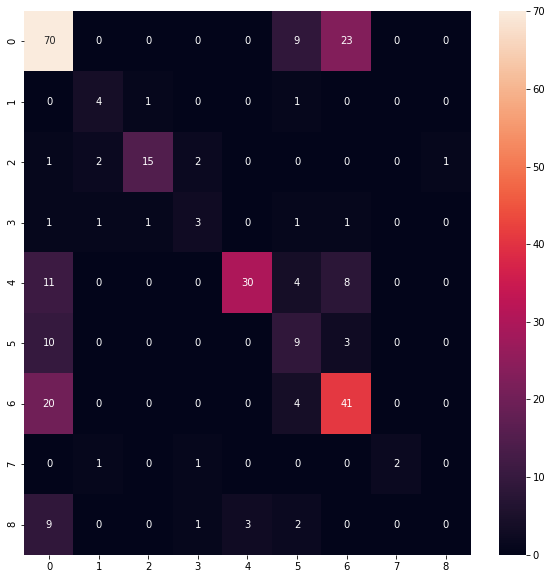

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

cf_matrix = confusion_matrix(y_test, parzen_predict)

import seaborn as sns

sns.heatmap(cf_matrix, annot=True)

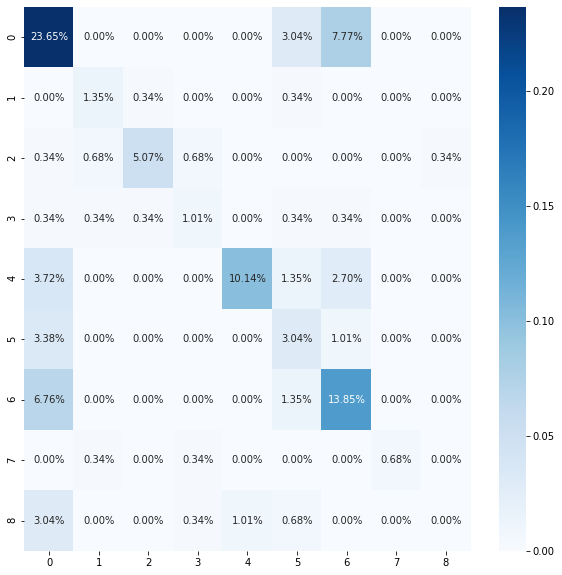

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [72]:
print(classification_report(y_test,parzen_predict))

              precision    recall  f1-score   support

         CYT       0.57      0.69      0.62       102
         EXC       0.50      0.67      0.57         6
         ME1       0.88      0.71      0.79        21
         ME2       0.43      0.38      0.40         8
         ME3       0.91      0.57      0.70        53
         MIT       0.30      0.41      0.35        22
         NUC       0.54      0.63      0.58        65
         POX       1.00      0.50      0.67         4
         VAC       0.00      0.00      0.00        15

    accuracy                           0.59       296
   macro avg       0.57      0.51      0.52       296
weighted avg       0.60      0.59      0.58       296

